# Import Library

In [1]:
import sys
sys.path.insert(0, "./timm-efficientdet-pytorch/")
sys.path.insert(0, "./omegaconf/")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch import nn
from glob import glob

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Load Dataset 

In [2]:
TRAIN_ROOT_PATH = f'../Datasets/mpii_human_pose_v1'

train_df = pd.read_csv(TRAIN_ROOT_PATH + f'/mpii_human_pose_v1_u12_2/train_dataset.csv')
val_df = pd.read_csv(TRAIN_ROOT_PATH + f'/mpii_human_pose_v1_u12_2/test_dataset.csv')

In [3]:
train_df.head()

,name,label,width,height,x1,y1,x2,y2,test
0,015601864.jpg,0,14,28,613,380,627,394,0
1,015601864.jpg,1,14,28,609,255,623,283,0
2,015601864.jpg,2,14,28,566,171,580,199,0
3,015601864.jpg,3,14,28,640,174,654,202,0
4,015601864.jpg,4,14,28,654,207,668,235,0


# Albumentation 

In [4]:
def get_train_transforms():
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

# Utils 

In [5]:
def drawPose(img, joints):
    relation = ((0, 1), (1, 2), (2, 6), (3, 4), (4, 5), (3, 6),
               (6, 7), (7, 8), (8, 9), (7, 12), (12, 11), (11, 10),
               (7, 13), (13, 14), (14, 15))
    
    for rel in relation:
        if joints[rel[0]] == [0, 0] or joints[rel[1]] == [0, 0]:
            if joints[rel[0]] == [0, 0] and joints[rel[1]] == [0, 0]: continue
            elif joints[rel[0]] == [0, 0]:
                cv2.circle(img = img,
                           center = (int(joints[rel[1]][0]), int(joints[rel[1]][1])),
                           radius = 10,
                           color = (255, 0, 0),
                           thickness = -1, )
            elif joints[rel[1]] == [0, 0]:
                cv2.circle(img = img,
                           center = (int(joints[rel[0]][0]), int(joints[rel[0]][1])),
                           radius = 10,
                           color = (255, 0, 0),
                           thickness = -1, )
            else: print("Drawing Error")
        
        else:
            start = (int(joints[rel[0]][0]), int(joints[rel[0]][1]))
            end = (int(joints[rel[1]][0]), int(joints[rel[1]][1]))
            color = (int(np.random.randint(0, 255, 1)[0]),
                     int(np.random.randint(0, 255, 1)[0]),
                     int(np.random.randint(0, 255, 1)[0]))
            # print(start, end, color)
            cv2.line(img, start, end,
                     color=color,
                     thickness=5)   
    return img


def drawHead(img, head):
    if 0 in head: return img
    
    start = (head[0], head[1])
    end = (head[2], head[3])
    cv2.rectangle(img, start, end, color=(255, 0, 0), thickness=5)
    return img

def drawAll(img, joints, head):
    img = drawPose(img, joints)
    img = drawHead(img, head)
    return img

# DataLoader 

In [6]:
TRAIN_ROOT_PATH = f'../Datasets/mpii_human_pose_v1'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        image, boxes = self.load_image_and_boxes(index)
        # there is only one class
        try:
            labels = np.array(self.marking['label'][self.marking['name']==image_id])
            labels = torch.as_tensor(labels, dtype=torch.int64)
        except ValueError:
            print(index, image_id)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break
        
        # print("Log : ", target)
        
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/images/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['name'] == image_id]        
        boxes = records[['x1', 'y1', 'x2', 'y2']].values
        return image, boxes


In [7]:
train_dataset = DatasetRetriever(
    image_ids=train_df['name'],
    marking=train_df,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=val_df['name'],
    marking=val_df,
    transforms=get_valid_transforms(),
    test=True,
)

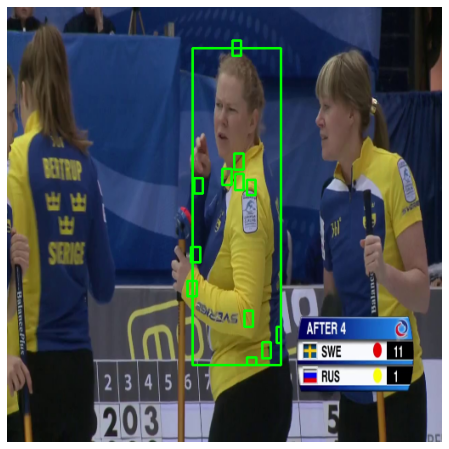

In [8]:
image, target, image_id = train_dataset[20]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

# Fitter 

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                
                if torch.cuda.device_count() > 1:
                    summary_loss.update(loss.detach().sum().item(), batch_size)
                else:
                    summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
                if self.config.verbose:
                    if step % self.config.verbose_step == 0:
                        print(
                            f'Train Step {step}/{len(train_loader)}, ' + \
                            f'summary_loss: {summary_loss.avg:.5f}, ' + \
                            f'time: {(time.time() - t):.5f}', end='\r'
                        )

                images = torch.stack(images)
                images = images.to(self.device).float()
                batch_size = images.shape[0]
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                self.optimizer.zero_grad()

                loss, _, _ = self.model(images, boxes, labels)

                if torch.cuda.device_count() > 1:
                    # Multi GPU
                    loss.sum().backward()
                    summary_loss.update(loss.detach().sum().item(), batch_size)
                else:
                    # Single GPU
                    loss.backward()
                    summary_loss.update(loss.detach().item(), batch_size)



                self.optimizer.step()

                if self.config.step_scheduler:
                    self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        if torch.cuda.device_count() > 1:
            saveModel = list(self.model.children())[0]
            torch.save({
                'model_state_dict': saveModel.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
                'epoch': self.epoch,
            }, path)
        else:
            torch.save({
                'model_state_dict': self.model.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
                'epoch': self.epoch,
            }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [11]:
class TrainGlobalConfig:
    num_workers = 0
    batch_size = 20
    n_epochs = 3 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet5-cutmix-augmix'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

# Load Model 

In [13]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d0')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('./efficientdet_pretrained/efficientdet_d0-d92fd44f.pth')
#     checkpoint = torch.load('./efficientdet_pretrained/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 17
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net, output_device = 1)

In [14]:
run_training()

Fitter prepared. Device is cuda:0

2020-07-16T11:03:44.292307
LR: 0.0002


ValueError: Expected y_max for bbox (0.6765625, 0.9847222222222223, 0.6953125, 1.0041666666666667, tensor(5)) to be in the range [0.0, 1.0], got 1.0041666666666667.